# A Comparison of Different Models for the Classification of Spoken Digits

### IT1244 Project, Team 31

**Team Members: Zhang Zhenjie, Ng Meng Jie, Lam Jian Yi Eugene, Muhammad Abu Ubaidah**

## Introduction

This project focuses on the Audio Classification of the Spoken Digits dataset and consists of 2 sections. In part 1, we train a Convolutional Neural Network (CNN) model for our audio classification task. Thereafter, we would tune the hyperparameters using the popular framework, Optuna. In part 2, we will further explore other traditional Supervised Learning Methods, evaluate their performance and compare it to the CNN model. While it may seem counterintuitive to start exploring models that are computationally intensive such as CNN, we realise from our research that CNN is a very common model used for audio classification tasks and thus we decided to explore it first.

The dataset we are using in this project is the Spoken Digits dataset. It consists of 3000 recordings from 6 speakers pronouncing a digit from 0 to 9. Each digit has 300 recordings and the recordings were captured at a sample rate of 8 kHz. For each of these audio clips, the first letter/string in the file name is its class label. More information on the dataset and the file hierarchies can be found in the **Readme.pdf** document.

## References

We referenced the following works for our project and would like to thank the authors of these pages:
- [TensorFlow](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [Optuna](https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py)
- [SKlearn](https://github.com/IliaZenkov/sklearn-audio-classification/blob/master/sklearn_audio_classification.ipynb)

For the TensorFlow tutorial, hyperparameter tuning is not implemented. Thus, to address this limitation, we incorporated hyperparameter tuning using Optuna.
For our various supervised learning models using Sci-kit learn, we explored a few models that were not taught in class.

## Part 1: CNN Model with Optuna for Hyperparameter Optimisation

The Convolutional Neural Network (CNN) is a variant of the Artificial Neural Network. It typically consists of 3 layer types:
- Convolutional layers
- Pooling layers
- Fully Connected layers

The presence of Convolutional Layers gives it its name. In general, CNNs are widely used in image and audio classification problems and we would like to explore it for our audio classification task. A more detailed explanation of CNNs can be found on this [website](https://en.wikipedia.org/wiki/Convolutional_neural_network).

### 1.1 Loading Packages

Before we start, we have to load all the necessary packages that we need for this project. If running the code chunk below returns an error saying the library does not exist, then we can do a simple pip install. For example, if `numpy` is not installed, then pasting the command `pip install numpy` into the command prompt will install `numpy` package to your system. For more details or commands to install other packages, refer to [PyPI website](https://pypi.org/).

In [1]:
# import packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from IPython import display
import librosa
import optuna
from optuna.visualization import plot_optimization_history
# Note: Optuna requires plotly to plot the graph. If you do not have it, please input `pip install plotly` in the cmd
import soundfile

#### 1.1.1 Checking the Versions of Packages

It is crucial that before we start, we check the version of Python and the libraries we are using. For certain libraries such as Tensorflow and Keras, they have different versions and certain functions may be deprecated or updated in an updated version. The list below shows some of the important libraries we are using and the corresponding versions. 

- Python Version: 3.10.6 (for the os module, we do not have to check because it is tagged to the current Python version)
- Matplotlib version: 3.5.2
- Numpy Version: 1.24.4
- Pandas Version: 1.4.3
- Seaborn Version: 0.11.2
- TensorFlow Version: 2.14.0
- Librosa version: 0.10.1
- Optuna version: 3.4.0
- Soundfile version: 0.12.1

Keras is integrated into TensorFlow 2.x, so we do not have to check its version.

In [2]:
# Print python version
import sys
print("Python version: ", sys.version) # for the os module, we do not have to check because it is tagged to the current Python version
print("Matplotlib version:", plt.matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("TensorFlow version:", tf.__version__) 
print("Librosa version:", librosa.__version__)
print("Optuna version:", optuna.__version__)
print("Soundfile version:", soundfile.__version__)

Python version:  3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Matplotlib version: 3.5.2
Numpy version: 1.24.4
Pandas version: 1.4.3
Seaborn version: 0.11.2
TensorFlow version: 2.14.0
Librosa version: 0.10.1
Optuna version: 3.4.0
Soundfile version: 0.12.1


#### 1.1.2 Setting the Seed for Reproducibility

The code below sets the seed so that our work would be reproducible. However, some TensorFlow functions are not fully deterministic and thus it is unlikely that we we get the same accuracy and loss for each run. Nevertheless, setting the seed will still help a little in making the accuracy and loss slightly more consistent across runs.

In [3]:
# Set the seed for reproducibility of results
# To ensure reproducibility, we need to set seeds at both the Python level and TensorFlow level
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) # ensures that hashing is also reproducible

# Ensure that TensorFlow operations are also reproducible
if tf.__version__.startswith("2"):
    tf.compat.v1.set_random_seed(seed)

if tf.__version__.startswith("1"):
    tf.set_random_seed(seed)

### 1.2 Loading of Dataset

We first want to get the correct directory to our data folder. Note that the code assumes that the dataset folder is named "data". If it has another name, please change `file=` in the code chunk below accordingly.

In [4]:
# Set the directory containing the dataset
path = os.getcwd()
file = 'data' #change if your dataset folder is not named as such
data_directory = os.path.join(path, file) # path of data folder
os.chdir(data_directory) #set current directory to be data folder 
print(data_directory)
print(os.getcwd())

c:\Zhenjie\University\Y2S1\IT1244\Project2\data
c:\Zhenjie\University\Y2S1\IT1244\Project2\data


The function we are going to use to load our dataset is `tf.keras.utils.audio_dataset_from_directory`. By default, it assumes that our dataset folder is of the structure:
```
main_directory/
...class_a/
......a_audio_1.wav
......a_audio_2.wav
...class_b/
......b_audio_1.wav
......b_audio_2.wav
```

However, the dataset that was given to us is of the following structure:
```
main_directory/
...a_audio_1.wav
...a_audio_2.wav
...
...b_audio_1.wav
...b_audio_2.wav
```

Therefore, we have to do a workaround. The code below reads the file names of all the audio files in the dataset folder, and then extracts the first digit/character. It is then converted to an integer and stored in a list. This list of class labels for all the audio files would then be passed into the `labels=` parameter in `tf.keras.utils.audio_dataset_from_directory` in the next code chunk. This allows us to use the function to load our audio dataset.

In [5]:
# Create to list with the labels of all the corresponding audio files to be supplied into the labels parameter in tf.keras.utils.audio_dataset_from_directory()
audio_files = [os.path.join(data_directory, file).replace("\\","/")  for file in os.listdir(data_directory) if file.endswith(".wav")]
# Define mappings for all the labels
label_to_int = {"0":0, 
                "1":1, 
                "2":2, 
                "3":3, 
                "4":4, 
                "5":5, 
                "6":6, 
                "7":7, 
                "8":8, 
                "9":9}  

labels = [label_to_int[file[0]] for file in os.listdir(data_directory) if file.endswith(".wav")]
print(labels)
print(len(labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

We check that we have labels for all 3000 audio files and proceed to load our audion dataset. The `tf.keras.utils.audio_dataset_from_directory` function will return a `tf.data.Dataset` object. More information can be found on their [website](https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory). We first load the training data set and validation data set. We opted for the most common 80-20 split. Our test data set will be created in a later portion.

In [6]:
# Load the dataset
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=os.getcwd(),
    batch_size=4,
    validation_split=0.2,
    labels=labels,
    seed=seed,
    shuffle=True,
    output_sequence_length=4000,
    subset='both')

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.


### 1.3 Data Visualisation and Data Pre-Processing

It is customary before we start training any models, that we visualise the data at hand so that we can pinpoint any problems with the dataset and find a solution to fix it. Also, it allows us to get a better feel of the type of data we are going to work with. In the process of visualisation, we would also process the data so that it would be ready to be used to train the CNN model.

#### 1.3.1 Visualisation of Duration of the Audio Files

We will start with a simple visualisation of the duration of each audio file.

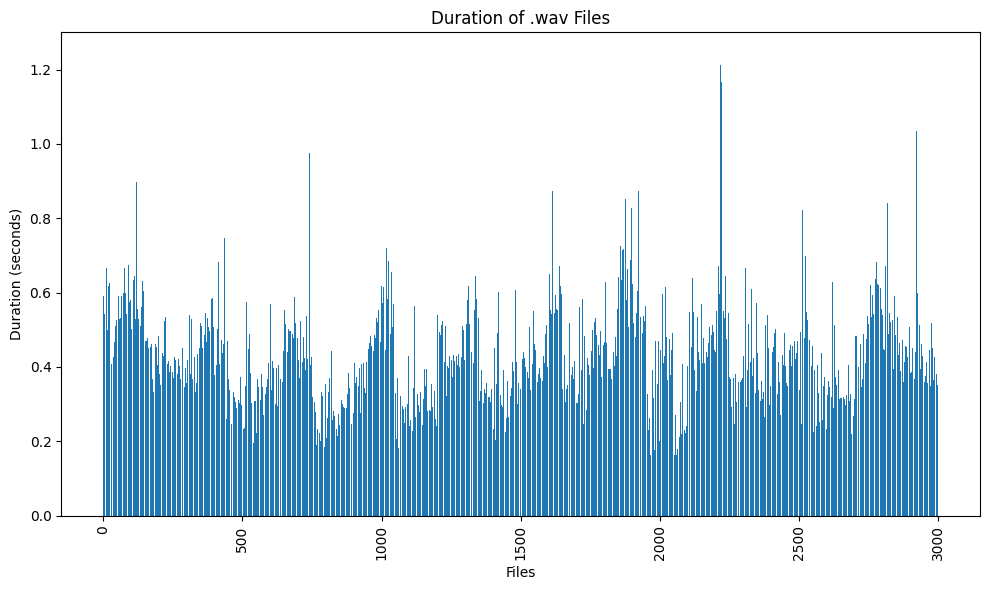

In [7]:
# Create empty lists to store file names and durations
file_names = []
durations = []

# Iterate through the .wav files in the folder
for filename in os.listdir(data_directory):
    if filename.endswith(".wav"):
        file_path = os.path.join(data_directory, filename)
        try:
            # Load the audio file and get its duration in seconds
            y, sr = librosa.load(file_path)
            duration = librosa.get_duration(y=y, sr=sr)
            # Append the filename and duration to the lists
            durations.append(duration)
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# Create a bar plot of the durations
plt.figure(figsize=(10, 6))
plt.bar(range(len(durations)), durations)
plt.xlabel("Files")
plt.ylabel("Duration (seconds)")
plt.title("Duration of .wav Files")
plt.xticks(rotation=90)
plt.tight_layout()

#Set the y-axis limit to 1.3 seconds
plt.ylim(0, 1.3)

# Show the plot
plt.show()


The above shows that the length of audio clips in the dataset is not standardised and would require pre-processing. However, we already solved this problem when we set the `output_sequence_length=` to a constant value of 4000 in the `tf.keras.utils.audio_dataset_from_directory` function that was used to load the audio dataset. This pads audio clips that are too short while trimming audio clips that are too long to ensure consistent inputs into the CNN model.

The value chosen is derived by multiplying the sampling rate of the audio files with its duration. (i.e. 8000Hz*0.5s = 4000)

#### 1.3.2 Train-Validation-Test Split

Before we do any further visualisations, we would like to complete our train-validation-test split so that we can process the data for spectrogram visualisation later on. The code below creates a separate test data set from the validation data set. The validation data set is meant to be used to test the model during training to see if it overfits. The test data set, on the other hand, is strictly meant for model evaluation.

We are creating the test data set using this method because the `tf.keras.utils.audio_dataset_from_directory` where we used to load the audio data can only return us two subsets of data - the training and validation set. Thus, we have obtained our test data set from the validation data set. This method thus creates an 80-10-10 train-validation-test split.

In [8]:
# Print the label names
label_names = np.array(train_ds.class_names)
print(label_names)

# Remove the extra axis in the dataset since the audio files are mono
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Create a separate test set from the validation set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

[0 1 2 3 4 5 6 7 8 9]


#### 1.3.3 Waveform Visualisation
We now would like to visualise the waveforms of a few samples of our audio recordings.

(4, 4000)
(4,)


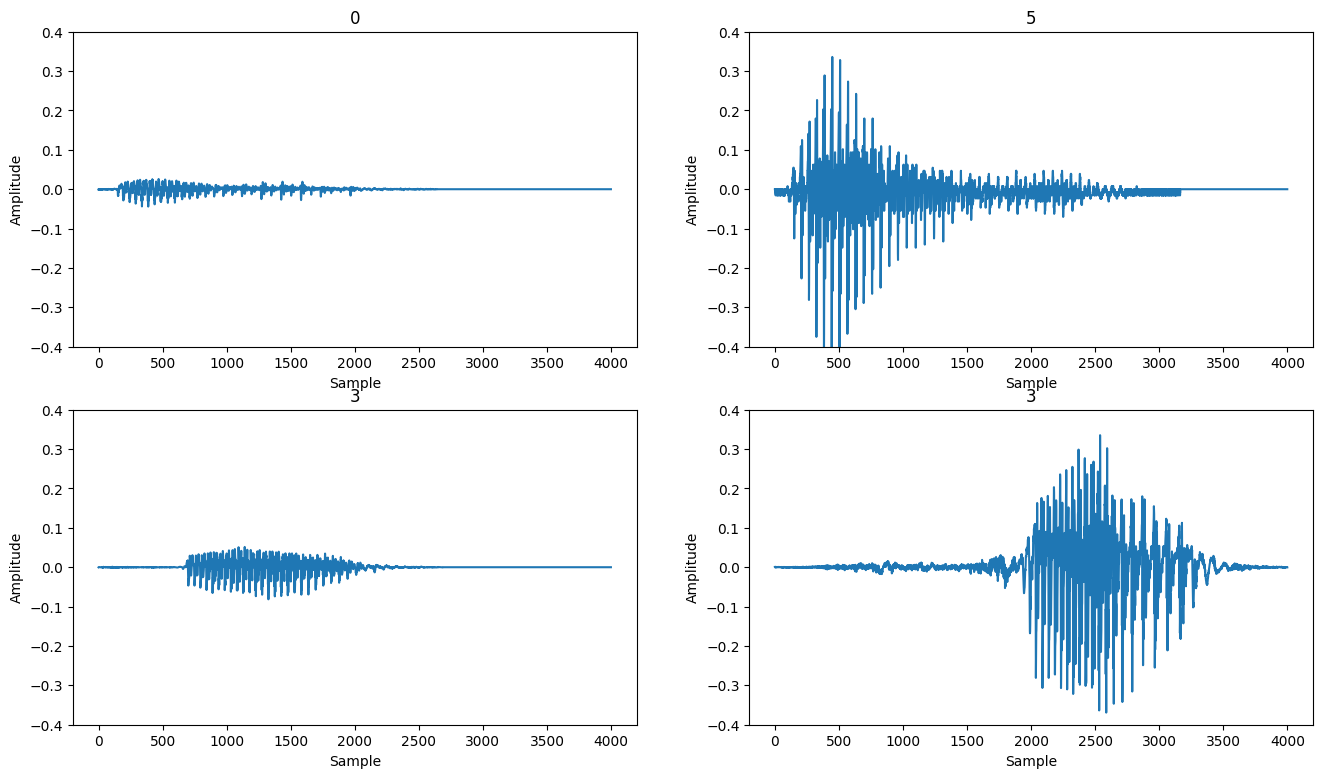

In [9]:
# Obtain samples from the dataset
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

# Plot the samples on a 2x2 grid
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(example_audio[i])
    plt.title(label_names[example_labels[i]])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.yticks(np.arange(-0.5, 0.5, 0.1))
    plt.ylim([-0.4, 0.4])
plt.show()

#### 1.3.4 Spectrogram Visualisation and Conversion of Dataset into Spectrogram Dataset
Before we can create the spectrogram, we have to transform the data. We use the helper function `get_spectrogram` which uses Short Time Fourier Transform (STFT) to transform our data into a spectrogram. More details on STFT will be discussed in Part 2 of this project. 

In the same code chunk, we also converted the train, validation and test data set into spectrogram data set so that it can be passed into the CNN.

Label: 0
Waveform shape: (4000,)
Spectrogram shape: (30, 129, 1)
Label: 5
Waveform shape: (4000,)
Spectrogram shape: (30, 129, 1)
Label: 3
Waveform shape: (4000,)
Spectrogram shape: (30, 129, 1)
Label: 3
Waveform shape: (4000,)
Spectrogram shape: (30, 129, 1)


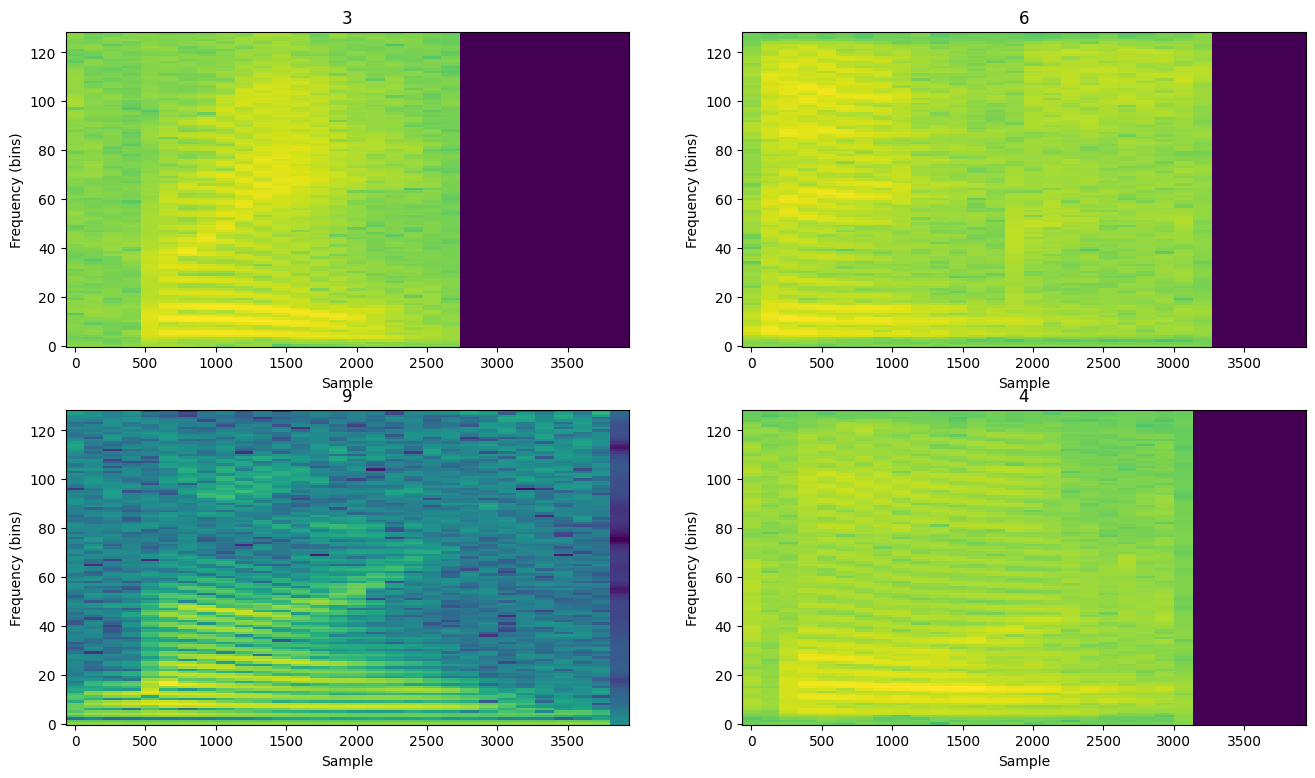

In [10]:
# Convert waveforms into spectrograms using Short Time Fourier Transform (STFT)
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)

  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

# Obtain the shapes of the waveforms and spectrograms for a few saples
for i in range(4):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)

# To plot spectrograms with specified axes
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

# Convert audio datasets into spectrogram datasets
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Plot the spectrograms of a few samples of audio on a 2x2 grid
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for example_spectrogram, example_label in train_spectrogram_ds.take(1):
    break

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrogram[i].numpy(), ax)
    ax.set_title(label_names[example_label[i].numpy()])
    ax.set_xlabel('Sample')
    ax.set_ylabel('Frequency (bins)')
plt.show()

#### 1.3.5 Normalisation
Now that we have our spectrogram datasets as inputs to our model, we created a normalisation layer which would later form part of our CNN model. This is a preprocessing layer which normalises continuous features. The aim of this is to reduce the variance of our features.

In [11]:
# Reduce read latency while training the model
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### 1.4 Initial Training of the Convolutional Neural Network Model

At this stage, we can finally train our model. However, we have no knowledge of what hyperparameters work best in the context of our audio classification task. Thus, we arbitrarily decided on the number of layers, the types of layers, the activation functions, the learning rate etc. The aim at this stage is to get a general sense of how a CNN model will perform for our audio classification task.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 16, 16, 1)         0         
                                                                 
 normalization (Normalizati  (None, 16, 16, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 64)         

Trainable params: 315146 (1.20 MB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________
Epoch 1/10
600/600 [==============================] - 4s 5ms/step - loss: 1.8056 - accuracy: 0.3762 - val_loss: 1.2683 - val_accuracy: 0.5933
Epoch 2/10
600/600 [==============================] - 3s 5ms/step - loss: 1.1679 - accuracy: 0.6025 - val_loss: 0.8096 - val_accuracy: 0.7600
Epoch 3/10
600/600 [==============================] - 3s 5ms/step - loss: 0.8095 - accuracy: 0.7163 - val_loss: 0.6518 - val_accuracy: 0.8033
Epoch 4/10
600/600 [==============================] - 3s 6ms/step - loss: 0.6264 - accuracy: 0.7858 - val_loss: 0.4612 - val_accuracy: 0.8800
Epoch 5/10
600/600 [==============================] - 3s 5ms/step - loss: 0.5227 - accuracy: 0.8313 - val_loss: 0.3852 - val_accuracy: 0.8800
Epoch 6/10
600/600 [==============================] - 3s 5ms/step - loss: 0.4103 - accuracy: 0.8612 - val_loss: 0.3456 - val_accuracy: 0.9033
Epoch 7/10

Text(0, 0.5, 'Accuracy [%]')

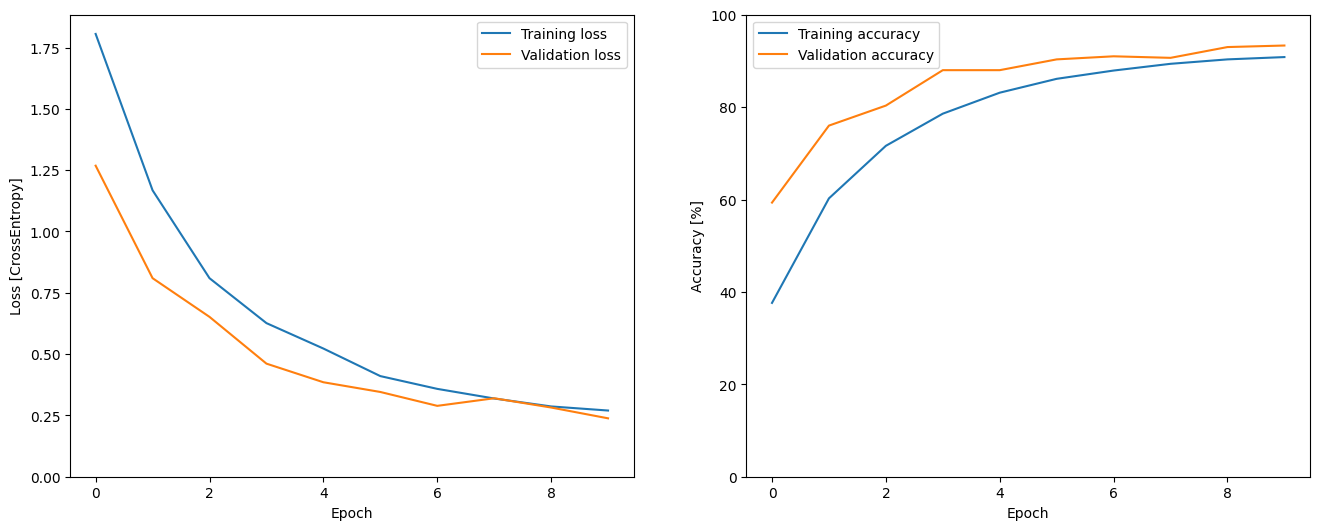

In [13]:
# Implement the model
model = keras.models.Sequential([
    layers.Input(shape=spectrogram.shape),
    # Downsize the input
    layers.Resizing(16, 16),
    # Normalise the input
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

# Set the learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Set the number of epochs and fit the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
)

# Plot the training & validation accuracy and loss curves
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

With the arbitrary hyperparameters that we decided, we observed that the run returned promising results. The high training and validation accuracy in the neighbourhood of 90% proves that this CNN model may be a good solution to our audio classification task. Do note that the accuracy may not be the same across different runs.

### 1.5 Hyperparameter Tuning

When dealing with CNNs, there exists a hyperparameter tuning framework, [Optuna](https://optuna.org), which we leveraged to help us optimise our hyperparameters. This is a more methodical approach to determining better choices for hyperparameters compared to trial-and-error. However, do note that Optuna will not return the BEST hyperparameters due to the following reasons:

- The optimal hyperparameter choices of hyperparameters we suggest to Optuna
- The number of trials we let Optuna test the hyperparameters

For these reasons, in the best-case scenarios, **Optuna will return the local optima. It will not be able to find the global optima**. That said, it is still useful in helping us further refine our model.

**Using the Optuna framework is a time and computationally-intensive process**. Therefore, we specified a list of pre-defined choices for Optuna to choose from instead of specifying a range for the various hyperparameters. Typically, people set the number of trials, `n_trials=` to be 50 to 100. During our runs, we did it with `n_trials=50` in the `study.optimize` function. It took around 40 minutes to complete the run. Also, for model evaluation, we supplied a validation data set instead of a test data set as we did not want to tune our model to perform well on the test data set. 

In the code, chunk below, we reduced `n_trails=5` to illustrate the process.

In [13]:
filters_choices = [16, 32, 64]
kernel_size_choices = [2, 3, 4]
strides_choices = [1, 2]
activation_choices = ["relu", "leaky_relu", "swish"]
pool_size_choices = [1, 2, 3]
rate_choices = [0.1, 0.2, 0.3, 0.4]
units_choices = [32, 64]

def objective(trial):
    model = keras.models.Sequential()
    model.add(layers.Input(shape=spectrogram.shape))
    model.add(layers.Resizing(32, 32))
    model.add(norm_layer)
    # suggest different filter num, filter size, strides, activation function for the convolutional layers
    model.add(layers.Conv2D(filters=trial.suggest_categorical("Conv_filter_1", filters_choices),
                            kernel_size=trial.suggest_categorical("Conv_kernel_size_1", kernel_size_choices),
                            strides=trial.suggest_categorical("Conv_strides_1", strides_choices),
                            activation=trial.suggest_categorical("Conv_activation_1", activation_choices)))
    model.add(layers.Conv2D(filters=trial.suggest_categorical("Conv_filter_2", filters_choices),
                            kernel_size=trial.suggest_categorical("Conv_kernel_size_2", kernel_size_choices),
                            strides=trial.suggest_categorical("Conv_strides_2", strides_choices),
                            activation=trial.suggest_categorical("Conv_activation_2", activation_choices)))
    # default arguments: MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
    # When not specified, the strides argument defaults to pool_size. 
    # In this case, the default stride will also be (2, 2), meaning that the pooling window will move 2 units in both the horizontal and vertical directions for each pooling operation.
    model.add(layers.MaxPooling2D(pool_size = trial.suggest_categorical("pool_size", pool_size_choices)))
    # suggest different values for the rate even though rate can take a continuous float value 
    # this is to reduce computational costs in determining the best dropout rate
    model.add(layers.Dropout(rate = trial.suggest_categorical("drop_rate_1", rate_choices),
                             seed = seed))
    model.add(layers.Flatten())
    model.add(layers.Dense(units = trial.suggest_categorical("Dense_units_1", units_choices),
                           activation = trial.suggest_categorical("Dense_activation_1", activation_choices)))
    model.add(layers.Dense(units = trial.suggest_categorical("Dense_units_2", units_choices),
                           activation = trial.suggest_categorical("Dense_activation_2", activation_choices)))
    model.add(layers.Dropout(rate = trial.suggest_categorical("drop_rate_2", rate_choices),
                             seed = seed))
    model.add(layers.Dense(num_labels))

    # Suggest a learning rate in a float range so that Optuna will give us a float value within that range
    # log=True indicates that the optimisation should be performed in the logarithmic space.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    EPOCHS = 10
    model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        verbose = 0)
    
    # Evaluate the model accuracy on the validation data set. Test data set only use for testing of final model
    score = model.evaluate(val_spectrogram_ds, verbose = 0)
    return score[1]

study = optuna.create_study(direction="maximize") # the aim is to maximise accuracy
study.optimize(objective, n_trials=5) # if we wish to terminate with a specified num of seconds, specify timeout =

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Print a graph of the the result of each of Optuna’s trials
# Note: Optuna requires plotly to plot the graph. If you do not have it, please input `pip install plotly` in the cmd
plot_optimization_history(study)

[I 2023-11-04 23:23:53,249] A new study created in memory with name: no-name-97209a3b-b4ab-4590-a144-8c97a3711fb8
[I 2023-11-04 23:25:05,382] Trial 0 finished with value: 0.9766666889190674 and parameters: {'Conv_filter_1': 32, 'Conv_kernel_size_1': 2, 'Conv_strides_1': 1, 'Conv_activation_1': 'relu', 'Conv_filter_2': 64, 'Conv_kernel_size_2': 4, 'Conv_strides_2': 2, 'Conv_activation_2': 'swish', 'pool_size': 1, 'drop_rate_1': 0.3, 'Dense_units_1': 64, 'Dense_activation_1': 'swish', 'Dense_units_2': 64, 'Dense_activation_2': 'relu', 'drop_rate_2': 0.1, 'learning_rate': 0.0002910267378573531}. Best is trial 0 with value: 0.9766666889190674.
[I 2023-11-04 23:25:20,710] Trial 1 finished with value: 0.4166666567325592 and parameters: {'Conv_filter_1': 16, 'Conv_kernel_size_1': 4, 'Conv_strides_1': 1, 'Conv_activation_1': 'leaky_relu', 'Conv_filter_2': 16, 'Conv_kernel_size_2': 2, 'Conv_strides_2': 2, 'Conv_activation_2': 'relu', 'pool_size': 3, 'drop_rate_1': 0.4, 'Dense_units_1': 64, 'Den

Number of finished trials: 5
Best trial:
  Value: 0.9766666889190674
  Params: 
    Conv_filter_1: 32
    Conv_kernel_size_1: 2
    Conv_strides_1: 1
    Conv_activation_1: relu
    Conv_filter_2: 64
    Conv_kernel_size_2: 4
    Conv_strides_2: 2
    Conv_activation_2: swish
    pool_size: 1
    drop_rate_1: 0.3
    Dense_units_1: 64
    Dense_activation_1: swish
    Dense_units_2: 64
    Dense_activation_2: relu
    drop_rate_2: 0.1
    learning_rate: 0.0002910267378573531


#### Results of our Run
![newplot 2.png](<attachment:newplot 2.png>)
```
Number of finished trials: 50
Best trial:
  Value: 0.9800000190734863
  Params: 
    Conv_filter_1: 64
    Conv_kernel_size_1: 4
    Conv_strides_1: 2
    Conv_activation_1: leaky_relu
    Conv_filter_2: 16
    Conv_kernel_size_2: 3
    Conv_strides_2: 1
    Conv_activation_2: relu
    pool_size: 2
    drop_rate_1: 0.2
    Dense_units_1: 64
    Dense_activation_1: swish
    Dense_units_2: 64
    Dense_activation_2: swish
    drop_rate_2: 0.4
    learning_rate: 0.0008116533397601633
```
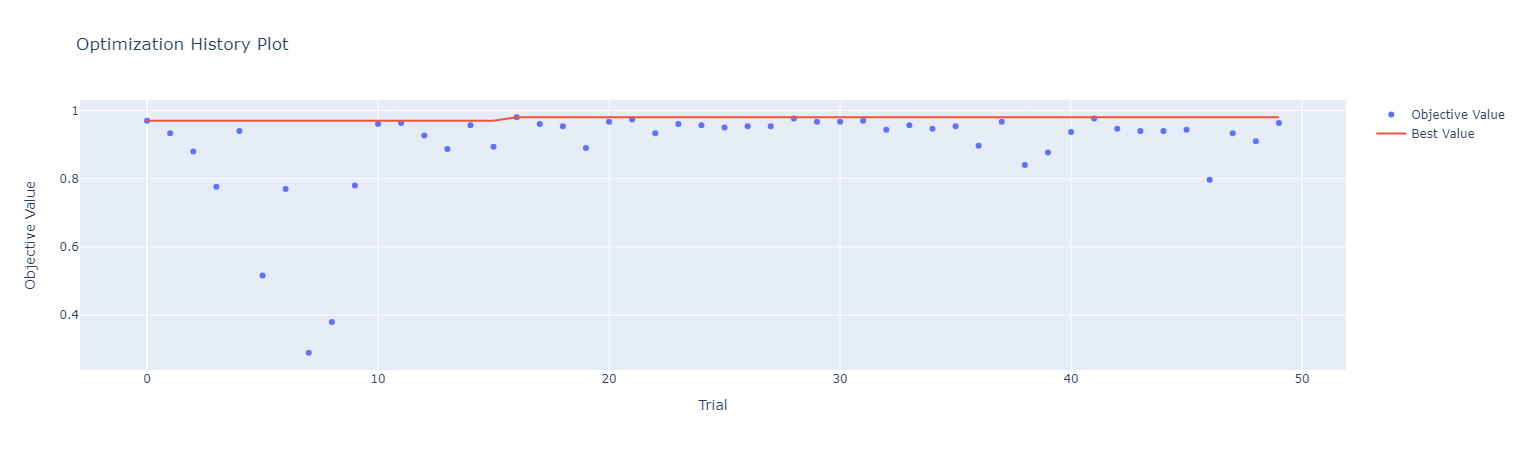

### 1.6 Creating a New Model

With the hyperparameters obtained from Optuna, we are now ready to train a CNN model. One of the changes we made to our model is that we changed the `layers.Resizing(16, 16)` to `layers.Resizing(32, 32)` because we realised that we might have downsized the input a little too much which could lead to information loss. Our model now consists of the following layer types:

- Input layer
- Resizing layer (to reduce the computational load)
- Normalisation layer (to reduce variance in our data)
- Convolutional layers (used to extract features)
- Pooling layer (to reduce the computational load as well)
- Dropout layers (to randomly drop some neurons to reduce overfitting)
- Dense/Fully Connected layers

This is the outline of our model training process:

1) Train the model with our training data set and then validate it with our validation data set
2) Plot the training and validation accuracy & loss curves
3) Evaluate the model using the test data and plot a confusion matrix

Also, we implemented early stopping, with a `patience=2` to prevent the model from overfitting. `patience=2` means that after 2 epochs, if there is no further improvement, training will be stopped.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 


 normalization (Normalizati  multiple                  3         
 on)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 64)        1088      
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 16)        9232      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 16)          0         
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                36928     
          

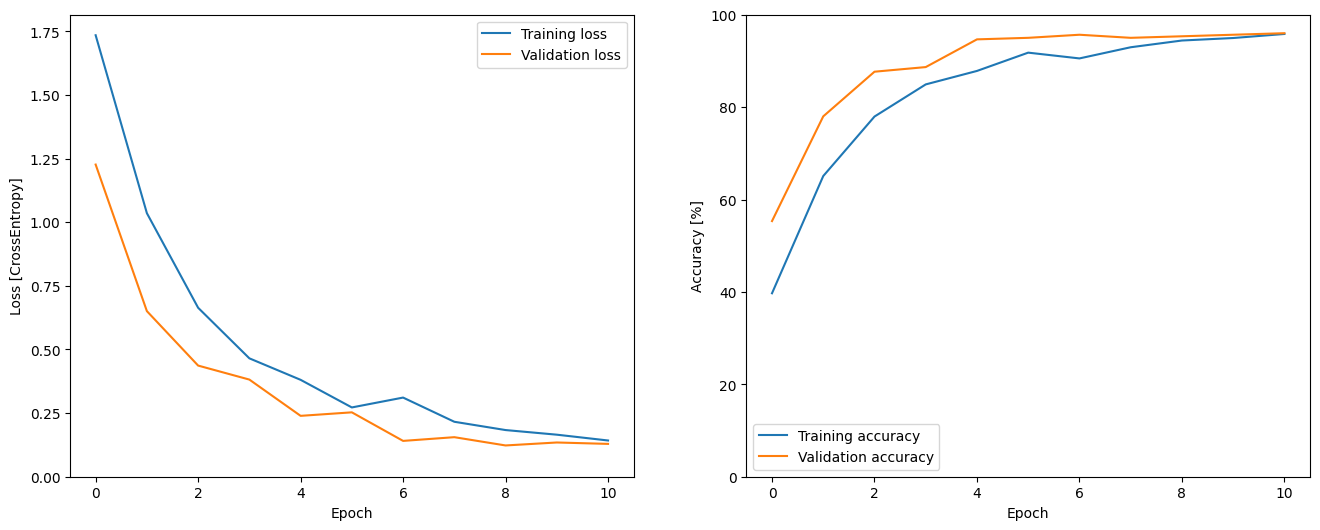

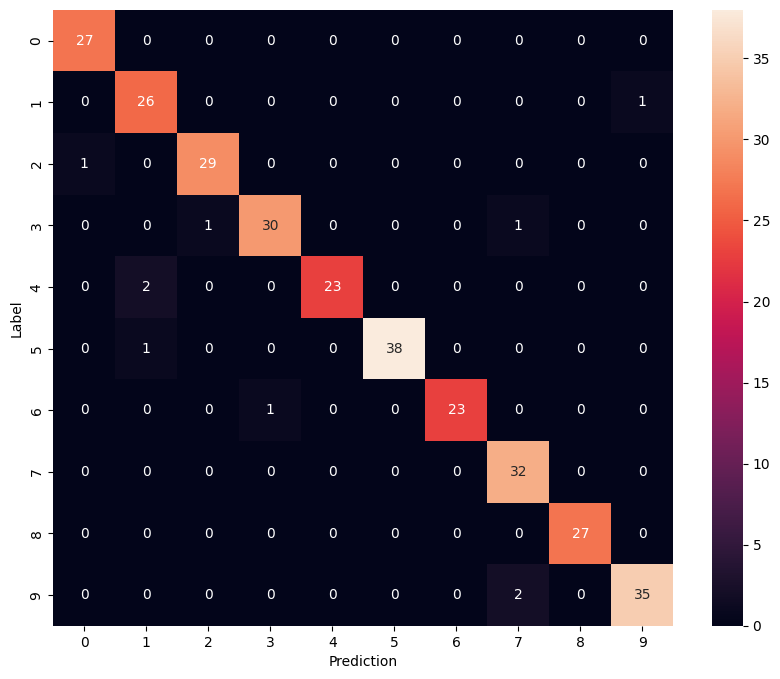

In [21]:

model = keras.models.Sequential([
    layers.Input(shape=spectrogram.shape),
    # Downsize the input
    layers.Resizing(32, 32),
    # Normalise the input
    norm_layer,
    layers.Conv2D(filters=64, kernel_size=4, strides=2, activation="leaky_relu"),
    layers.Conv2D(filters=16, kernel_size=3, strides=1, activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2, seed = seed),
    layers.Flatten(),
    layers.Dense(64, activation="swish"),
    layers.Dense(64, activation="swish"),
    layers.Dropout(0.4, seed = seed),
    layers.Dense(num_labels),
])

model.summary()

# Set the learning rate
learning_rate = 0.000812

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Set the number of epochs and fit the model
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

# Plot the training & validation accuracy and loss curves
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


# Plot a confusion matrix to compare predicted and actual results
model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

From our own runs, we noticed that the model with the new hyperparameters performed better. The graph above shows a low loss and high accuracy which means that our model is performing well. The gap between the training and validation curves is small which suggests that we are not overfitting. The diagonal entries in the confusion matrix tell us the number of correct predictions for each class label. Any other numbers found in non-diagonal entries mean that we have a wrong prediction. We can see from the confusion matrix that the model performs well on the unseen test data set too.

Compared to previously done work, our CNN model shows similar performance. Our model outperformed [a similar STFT-CNN model](http://www.wcse.org/WCSE_2021_Spring/002.pdf) that had an accuracy of 90.4% for spoken English digits. However, [another CNN model](https://doi.org/10.1109/AiIC54368.2022.9914596) which used Bark spectrograms as part of feature extraction achieved an average accuracy of over 99%. Therefore, while the results of our current model are promising, more can be done to further optimise its performance.

## Part 2: Exploring Other Supervised Learning Models

We have seen how CNN was able to provide us with a great degree of accuracy and low loss. But we are also interested in how the traditional supervised learning methods perform in the context of Audio Classification. However, traditional supervised learning methods require specific features to be able to train the model. This is unlike our CNN model where we can just pass a spectrogram image into the CNN and use the convolutional layers to help us "extract" the features. Thus, there is more work to be done in the aspect of Data Visualization and Feature Engineering.

### 2.1 Data Visualisation

Data visualisation is an import step before training any models in general because we need to get a sensing of how our data looks like so that we can identify problems that exist in our data before we train our models which could lead to greater model accuracy etc.

#### 2.1.1 Visualising Waveforms 

We first visualise our waveforms so that we have a better idea of what our audio files look like and look out for anything that might be potentially interesting. First off, we already noticed that the audio duration for the 2 samples is different.

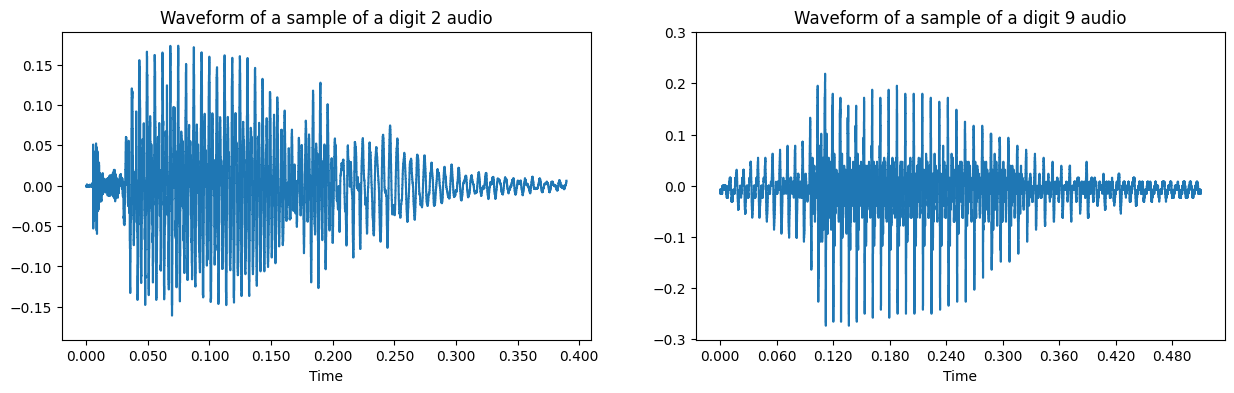

In [5]:
audio_sample_1_path = os.path.join(data_directory, "2_A_17.wav")
audio_sample_2_path = os.path.join(data_directory, "9_D_10.wav")

with soundfile.SoundFile(audio_sample_1_path) as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title('Waveform of a sample of a digit 2 audio')

with soundfile.SoundFile(audio_sample_2_path) as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title('Waveform of a sample of a digit 9 audio')

#### 2.1.2 Short-Time Fourier Transform Visualisation

The most common data pre-processing technique in time series signal processing is the Fourier Transform. In particular, we would like to use the Short-Time Fourier Transform (STFT) which cuts our audio waveform into short, overlapping equal-length segments, then takes the Fourier transform of each segment individually to produce multiple power spectrograms, identifying resonant frequencies present in each audio file. The major advantage of STFT is better resolution of changes in the audio signal with time.

In [6]:
with soundfile.SoundFile(audio_sample_1_path) as audio:
    digit_2_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile(audio_sample_2_path) as audio:
    digit_9_waveform = audio.read(dtype="float32")

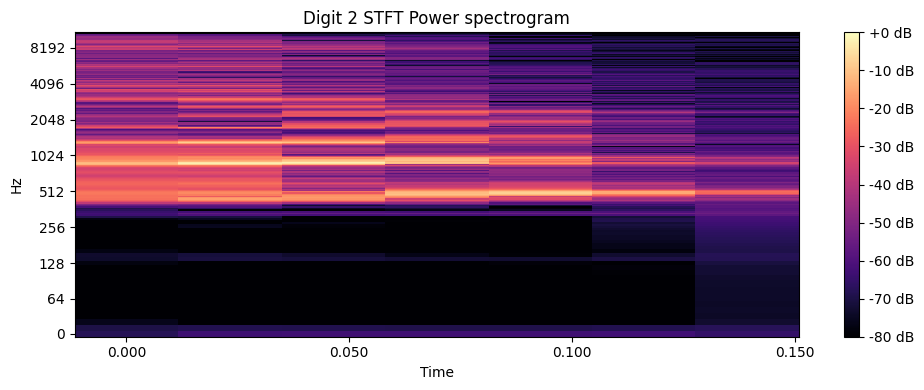

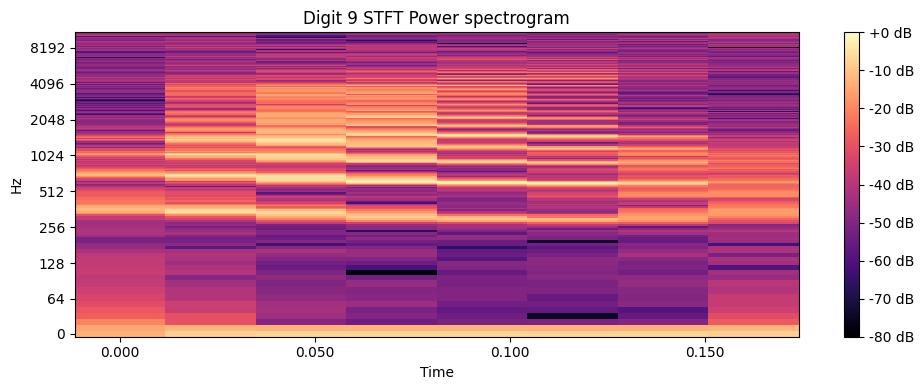

In [7]:
stft_spectrum_matrix = librosa.stft(digit_2_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Digit 2 STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(digit_9_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('Digit 9 STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

#### 2.1.3 Mel-Frequency Cepstral Coefficients Visualisation

We would like to build on the STFT by using the Mel Frequency Cepstral Coefficients (MFCCs) as a feature in our model. To put it simply, MFCC is a mathematical method which transforms the power spectrum of an audio signal to a small number of coefficients representing the power of the audio signal in a frequency region (a region of pitch) taken w.r.t. time.

In other words, MFCCs give us an idea of the changing pitch of an audio signal.

In the code below, we used 40 filterbanks to produce 40 coefficients by setting `n_mfcc = 40`

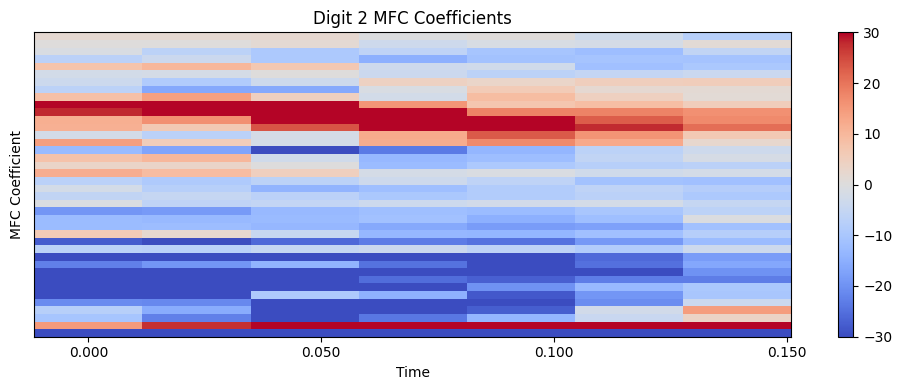

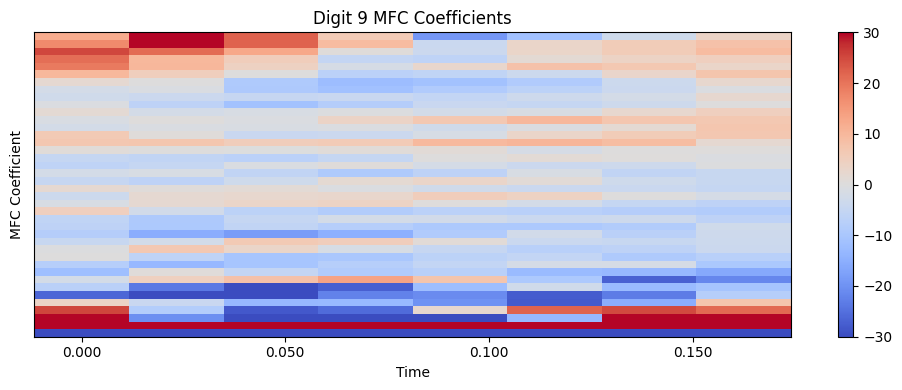

In [8]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=digit_2_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Digit 2 MFC Coefficients')
plt.tight_layout()
                                        
mfc_coefficients = librosa.feature.mfcc(y=digit_9_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('Digit 9 MFC Coefficients')
plt.tight_layout()

Positive MFCCs correspond to low-frequency regions of the cepstrum, and negative MFFCs to high-frequency.

We see that the digit 2 sample has more darker reds but also darker blues compared to digit 9. This could mean that the speaker for digit 2 can vary his/her pitch more than the speaker for digit 9 in this case.

#### 2.1.4 Mel Spectrograms and Mel-Frequency Cepstrums Visualisation

In deriving MFCCs, we have also produced an additional feature we can make use of. When we mapped the frequencies of a power spectrogram to the mel scale, we produced a Mel Frequency Spectrogram - a simple analogue of the power spectrogram with the frequency scale in mels. We wish to incorporate this into our model too.

In this visualisation, we chose `n_mels=40`. On the other hand, `fmax` is a parameter that represents the upper limit or maximum frequency of the filter banks and in this case we set it to 8000Hz. 

c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


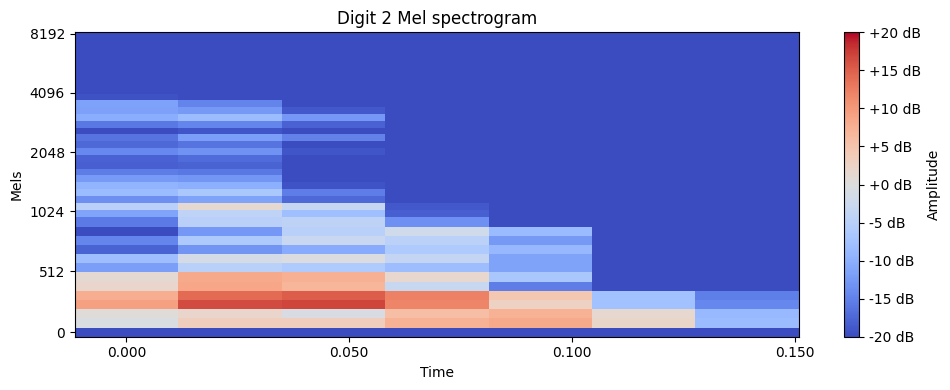

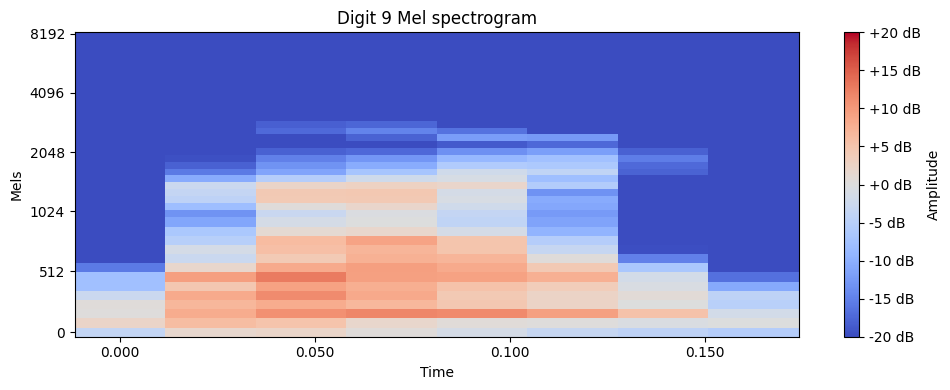

In [9]:
melspectrogram = librosa.feature.melspectrogram(y=digit_2_waveform, sr=sample_rate, n_mels=40, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Digit 2 Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=digit_9_waveform, sr=sample_rate, n_mels=40, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('Digit 9 Mel spectrogram')
plt.tight_layout()

#### 2.1.5 Chromagram Visualisation

Another feature that could be incorporated into our model is the chromagram. To do so, we are going to build a chromagram on each power spectrogram computed by STFT. A chromagram is a representation of an audio signal with respect to time that maps each audio signal to a pitch class. Most often, we map to the 12 standard pitch classes (i.e. the musical scale CDEFGAB and 5 additional semitones give us 12 pitch classes in total).

To put it simply, it represents energy distribution across the 12 pitch classes in the Western musical scale w.r.t time. A caveat is that a higher position in a chromagram does not necessarily mean a higher pitch because different octaves of the same note are grouped together. The chromagrams essentially groups similar notes from different octaves into the same bin. The diagram below taken from [Wikipedia](https://en.wikipedia.org/wiki/Chroma_feature#/media/File:ChromaFeatureCmajorScaleScoreAudioColor.png) will help illustrate this concept clearly.

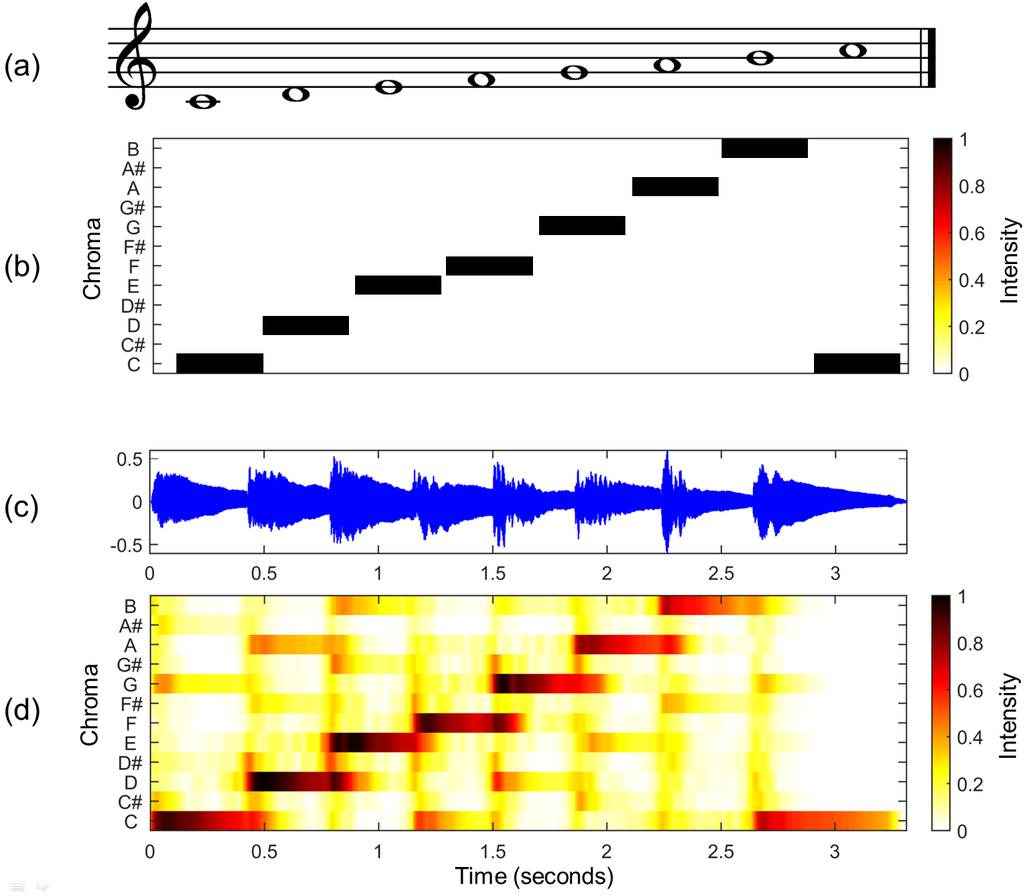

Notice that the C note from a higher octave is binned together with the C note from the lower octave. However, we can still follow the general direction of pitch movement in a chromagram to determine if the pitch is going up or down. 

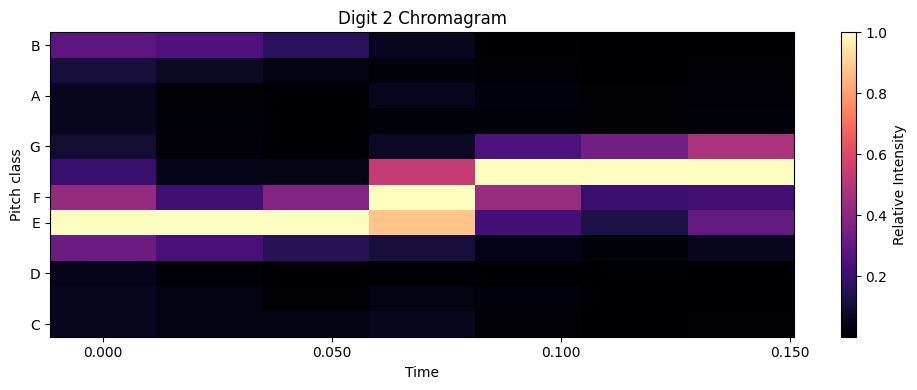

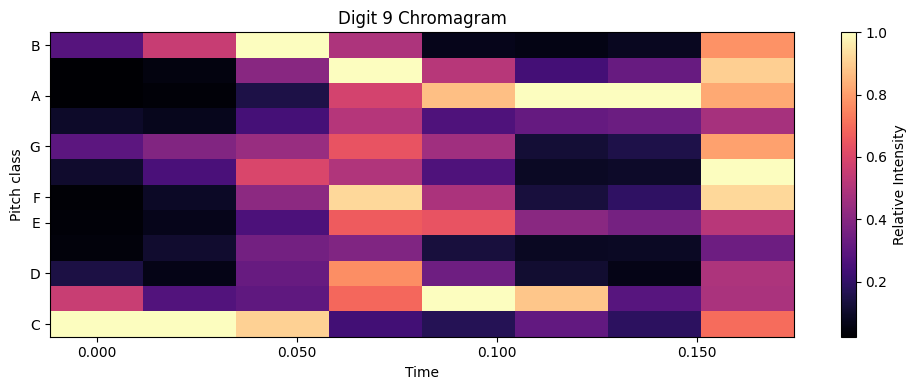

In [14]:
chromagram = librosa.feature.chroma_stft(y=digit_2_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Digit 2 Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=digit_9_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Digit 9 Chromagram')
plt.tight_layout()

From the chromagram of digit 2, we can conclude that as the speaker speaks, his/her pitch increases as seen from the upward motion of intensity from the pitch E to F# across the duration of the recording. We can confirm this by playing the actual audio clip.

In [16]:
from IPython.display import Audio, display

y, sr = librosa.load(audio_sample_1_path)

# Play the audio
display(Audio(data=y, rate=sr))

### 2.2 Feature Extraction

Although the features we have discussed so far are closely related to each other, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features for better distinguishing power between each sample.

We now want to create our feature extraction functions to get a chromagram, a mel spectrogram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

- **Chromagram:** Will produce 12 features, one for each of the 12 pitch classes

- **Mel Spectrogram:** Will produce 40 features. We have defined the number of mel frequency bands at n_mels=40 previously

- **MFCC:** Will produce 40 MFCCs. We have set the number of coefficients to return at n_mfcc=40

In [15]:
def feature_chromagram(waveform, sample_rate):
    # STFT is computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # We use 8kHz as upper frequency bound as it is the most common for audio classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=40, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

We wrap our 3 feature extraction functions with a new function `get_features` so that we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we can stack them horizontally to create a single feature array.

In [16]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        
        return feature_matrix

#### 2.2.1 Load the Dataset and Compute the Features

In [17]:
def load_data():
    X,y=[],[]
    for file in os.listdir(data_directory):
        file_name=os.path.join(data_directory, file)
        audio_label = file[0] # the first letter of the file name is the class label
        features = get_features(file)
        X.append(features)
        y.append(audio_label)
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [18]:
features, digits = load_data()

c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
c:\Users\zzhen\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
c:\Users\zzhen\AppData\Local\Programs\Python\Python310\

Let's see what the features we extracted look like:

In [19]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it nice for display
features_df


Audio samples represented: 3000
Numerical features extracted per sample: 92


,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.482366,0.289349,0.176958,0.402827,0.729235,0.636647,0.401065,0.344801,0.390424,0.459365,...,26.824957,19.878748,3.438735,-3.167130,-9.609977,1.313905,-4.146323,-5.467860,-5.199466,2.401037
1,0.465819,0.261374,0.299730,0.632390,0.983048,0.595723,0.472383,0.408199,0.547336,0.515950,...,24.821976,21.457653,4.547133,1.927477,-2.413096,6.867043,-6.124772,-0.163095,-0.760737,-1.982047
2,0.409174,0.324911,0.279367,0.518963,0.537372,0.493668,0.387211,0.367940,0.461984,0.568958,...,21.513275,25.965521,14.020282,5.103598,-5.102735,2.622404,0.667325,0.394782,-5.752989,2.109235
3,0.514262,0.216885,0.230398,0.529620,0.736345,0.539458,0.335688,0.296354,0.429443,0.413100,...,37.956116,23.416000,-1.317131,3.128314,-1.574930,10.699871,-6.403910,-7.323116,2.396571,6.027065
4,0.317763,0.195210,0.187897,0.510585,0.655315,0.476636,0.352914,0.294767,0.371388,0.422168,...,32.731026,22.578979,4.684443,-3.104899,-3.156140,3.812025,-9.905424,-2.281693,2.553234,4.209818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.779703,0.799270,0.605759,0.439271,0.740589,0.637679,0.554921,0.721865,0.785489,0.575315,...,-11.708669,-10.247458,-12.768601,4.274331,17.907335,19.953552,22.612692,16.661674,7.659466,3.999020
2996,0.577742,0.793772,0.816211,0.744604,0.833116,0.673808,0.607233,0.678460,0.656051,0.726983,...,-9.161119,-6.459507,-7.215691,-2.293252,-4.804932,-6.465489,-2.927311,-1.292374,-6.735821,-8.093297
2997,0.582768,0.496679,0.608591,0.687656,0.914278,0.733470,0.477196,0.532574,0.667433,0.609496,...,-2.548957,-9.641240,-5.692091,4.460363,1.912006,-4.423185,0.677252,6.764740,0.031235,-1.278873
2998,0.403141,0.600786,0.509718,0.605737,0.941526,0.497662,0.417146,0.480804,0.545275,0.820036,...,-5.773128,-4.312113,-6.717234,-3.907943,-2.028272,-5.211774,-6.615764,-2.032895,-1.613782,-1.738494


We observe that we have a size of 3000 x 92. Each row has 92 features. The 92 features consist of 2 chromagram pitch classes + 40 mel spectrogram bands + 40 MFC coefficients.

We now check if our dataset is balanced (i.e. each of the 10 classes of digits has an equal number of audio files).

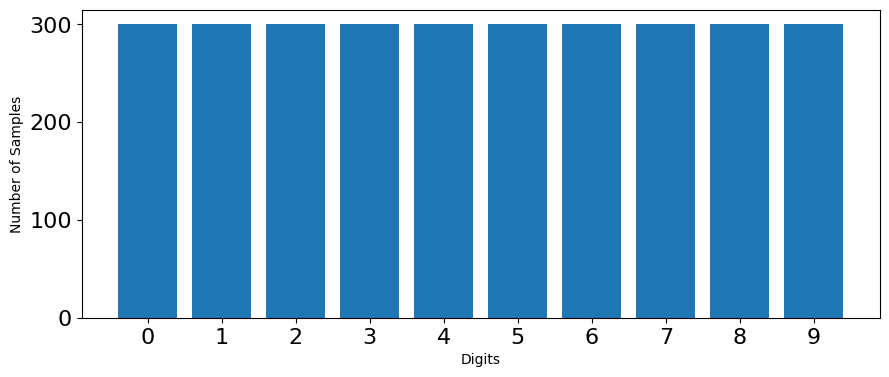

In [20]:
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns an ordered list of unique elements and a count of each element
digits_list, count = np.unique(digits, return_counts=True)
plt.bar(x=range(10), height=count)
plt.xticks(ticks=range(10), labels = [digit for digit in digits_list],fontsize=10)
plt.xlabel('Digits')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

The classes appear to be balanced which is great. So we can now move on.

#### 2.2.2 Feature Scaling

To properly train most machine learning models on most datasets, we need to first scale our features. This is crucial for models which use distance metrics such as KNN. If we do not do feature scaling, the model may give more importance to features that are larger in magnitude. Therefore, distance metrics would only be useful if the same scale is used.

We first check our features' properties:

In [21]:
# We would usually use df.describe(), but it provides a bit of a mess of information that we do not need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11] # first 12 features are from the chromagram
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we do not get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}') 

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:51] # next 40 features are mel spectrogram
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n 40 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,52:91] # last 40 features are MFCC features
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we do not get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n 40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')
    
print_features(features_df)

12 Chromagram features:           min = 0.090,     max = 1.000,     mean = 0.588,     deviation = 0.169

 40 Mel Spectrogram features:     min = 0.000,     max = 172.465,     mean = 0.787,     deviation = 3.650

 40 MFCC features:                 min = -544.709,    max = 191.390,    mean = -9.854,    deviation = 46.673


Notice that there is an obvious imbalance in the variance of our features. This also implies that our features belong to very different distributions. The deviation for MFCCs is vastly greater than the other features. However, that does not mean MFCCs are the most important feature and thus we will need to do some scaling on this feature set.

There are usually 2 choices for scaling: sklearn's `StandardScaler` and `MinMaxScaler`. `StandardScalar` subtracts the mean of each feature and divides by the standard deviation of that feature, resulting in features that have a mean of 0 and standard deviation & variance of 1. `MinMaxScaler` on the other hand, transforms each feature to be within a bounded interval that is specified by us.

In practice, Min-Max scaling is especially useful when we know our features should be in a bounded interval**, such as pixel values in [0,255], while standard scaling is perhaps more practical for features with unknown distributions because centring the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights (i.e. the model is less sensitive to outliers).

In this case, we do not know the distribution of our data. But we will still create Min-Max scaled features so that we can verify if standard scaling is better for our dataset's features later on.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features 
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

Making sure our features are properly scaled:

In [23]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -3.402,     max = 2.813,     mean = 0.000,     deviation = 1.000

 40 Mel Spectrogram features:     min = -0.795,     max = 36.587,     mean = -0.000,     deviation = 0.894

 40 MFCC features:                 min = -4.244,    max = 10.399,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.515,     deviation = 0.197

 40 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.070

 40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.419,    deviation = 0.184


### 2.3 Training Models

We are interested to train and compare the following models:

- K-Nearest Neighbours
- Decision Tree
- Gaussian Naive Bayes

#### 2.3.1 Train-Test Split

To compare models, we will have to evaluate their performance. The simplest method to do so is to train a model on a portion of our dataset and test it on the remainder. We will use sklearn's `train_test_split` to create a standard 80/20 train/test split. The model is fit on 80% of the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

More accurately, the proper modality for training and scoring a model is to:

- Fit/train our model on a training set,
- Evaluate the model on a validation set to tune the hyperparameters for better performance,
- Finally score our model's true performance - its generalisability - against a test set, aka the hold-out set.
- Repeat from 2. Do not tune the model to score well on the test set.

However, in our case, we are only exploring the performance of different models without doing hyperparameter tuning. Thus we would be doing a simpler 80/20 train-test split instead of the 80/10/10 train-validation-test split.

We created 3 different sets of data so that for models that use distance-based metrics we can use the appropriate data.

In [24]:
from sklearn.model_selection import train_test_split

############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    digits, 
    test_size=0.2, 
    random_state=seed
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_standard, X_test_standard, _, _ = train_test_split(
    features_scaled, 
    digits, 
    test_size=0.2, 
    random_state=seed
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax, 
    digits, 
    test_size=0.2, 
    random_state=seed
)

#### 2.3.2 K-Nearest Neighbours (KNN) Classifier

KNN is a supervised machine learning method from the 70s. The basic idea surrounding this model is that we plot our training samples' features and compare a test sample's features' distance to all those points, then take the k closest points to the test sample and pick the most frequent label/class. This method is based on the assumption that data points that are close share similar features and therefore are more likely to belong to the same class. However, since it uses distance metrics to measure feature similarity, it would be appropriate to use our scaled dataset to train our model in this case.

This classifier has the following properties:
- Non-parametric - no assumptions are made on the underlying data distribution which means it works well for both linear and non-linear data
- Lazy learning - no need for parameters to learn and predictions are only made when test data is inputted

The downside of this model is that for large datasets, it is extremely memory-hungry as it has to store all the data points. It is also computationally expensive as it has to calculate the distance of the new test data point to all the training data points before sorting the distance.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train_standard, y_train) # using standardised data

print(f'Default kNN Model\'s accuracy on standardised training set is {100*model.score(X_train_standard, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on standardised training test set is {100*model.score(X_test_standard, y_test):.2f}%\n')

model.fit(X_train_minmax, y_train) #using min max scaled data

print(f'Default kNN Model\'s accuracy on min-max scaled training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on min-max scaled training test set is {100*model.score(X_test_minmax, y_test):.2f}%\n')

##### Tweaking some parameters ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'kd_tree',
    leaf_size = 35,
    n_jobs=5
)

model.fit(X_train_standard, y_train)

print(f'Tweaked kNN Model\'s accuracy on training set is {100*model.score(X_train_standard, y_train):.2f}%')
print(f'Tweaked kNN Model\'s accuracy on test set is {100*model.score(X_test_standard, y_test):.2f}%\n')

model.fit(X_train_minmax, y_train)

print(f'Tweaked kNN Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'Tweaked kNN Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%')

Default kNN Model's accuracy on standardised training set is 95.08%
Default kNN Model's accuracy on standardised training test set is 92.33%

Default kNN Model's accuracy on min-max scaled training set is 95.21%
Default kNN Model's accuracy on min-max scaled training test set is 92.17%

Tweaked kNN Model's accuracy on training set is 100.00%
Tweaked kNN Model's accuracy on test set is 91.83%

Tweaked kNN Model's accuracy on training set is 100.00%
Tweaked kNN Model's accuracy on test set is 92.50%


We note that the accuracy on the K-Nearest Neighbours model is fairly stable in general, hovering in the range of 91% to 92%. For the default model, it performs better on the standardised data while for the tweaked model, it performs better on the min-max scaled data.

#### 2.3.3 Decision Tree Classifier
Decision Trees (DTs) are non-parametric supervised learning methods used for classification and regression problems. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the variance in the data. Thus we would be using the unscaled dataset

Some advantages of decision trees are:
- They are simple to understand and interpret as trees can be visualised.
- The cost of using the tree (i.e. predicting data) is logarithmic in the number of data points used to train the tree.

Some disadvantages of decision trees are:
- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

In [26]:
from sklearn.tree import DecisionTreeClassifier

####### Default Decision Tree ########

model = DecisionTreeClassifier(random_state=seed)

model.fit(X_train, y_train)

print(f'Default Decision Tree Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Decision Tree Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

########## Tweaking some parameters #######
model = DecisionTreeClassifier(criterion="entropy", # default is gini
                               random_state=seed)

model.fit(X_train, y_train)

print(f'Entropy Criterion Decision Tree Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Entropy Criterion Tree Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

model = DecisionTreeClassifier(criterion="log_loss", # using log-loss 
                               random_state=seed)

model.fit(X_train, y_train)

print(f'Log-loss Criterion Tree Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Log-loss Criterion Tree Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Decision Tree Model's accuracy on training set is 100.00%
Default Decision Tree Model's accuracy on test set is 75.00%

Entropy Criterion Decision Tree Model's accuracy on training set is 100.00%
Entropy Criterion Tree Model's accuracy on test set is 75.50%

Log-loss Criterion Tree Model's accuracy on training set is 100.00%
Log-loss Criterion Tree Model's accuracy on test set is 75.50%


The criterion function is a function to measure the quality of a split. We have 3 different criteria that are available for us to choose from, with the default being the Gini impurity. We observe that all 3 gave a decent accuracy score, but are still lower than the CNN model in Part 1 and the KNN model in the previous section. However, the entropy and log-loss criterion seems to perform marginally better in this case with a slight 0.50 percentage point increase in accuracy.

#### 2.3.4 Gaussian Naive Bayes Classifier

Naive Bayes Classifiers are a set of supervised learning algorithms that make use of Bayes' theorem with the naive assumption of conditional independence between each pair of features given the value of the class variable. Bayes' theorem states the following relationship given class variable $y$ and dependent feature vector $x_{1}$ through $x_{n}$:

\begin {align*}
    P(y|x_{1},...,x_{n}) = \frac{P(y)P(x_{1},...,x_{n}|y)}{P(x_{1},...,x_{n})}
\end {align*}

Using the naive conditional independence assumption that 

\begin{align*}
    P(x_{i}|y,x_{1},...,x_{i-1},x_{i+1},...,x_{n}) = P(x_{i}|y)
\end{align*}

for all $i$, this relationship is simplified into

\begin {align*}
    P(y|x_{1},...,x_{n}) = \frac{P(y) \prod_{i=1}^{n} P(x_{i}|y)}{P(x_{1},...,x_{n})}
\end {align*}

Since $P(x_{1},...,x_{n})$ is constant given the input, we can use the following classification rule:

\begin {align*}
    P(y|x_{1},...,x_{n}) \propto P(y) \prod_{i=1}^{n} P(x_{i}|y) \\
    \hat{y} = \text{arg} \max_{y} P(y) \prod_{i=1}^{n} P(x_{i}|y)
\end {align*}

In our case of Gaussian Naive Bayes algorithm, the likelihood of features is assumed to be Gaussian:

\begin{align*}
    P(x_{i}|y) = \frac{1}{\sqrt(2 \pi \sigma_{y}^{2})} \exp\left(-\frac{(x_{i} - \mu_{y})^2}{2 \sigma_{y}^2} \right)
\end{align*}

Gaussian Naive Bayes Classifier is just one variant of Naive Bayes Classifier. Other variants can be found on [scikit-learn's website](https://scikit-learn.org/stable/modules/naive_bayes.html).

Naive Bayes Classifiers are not dependent on distance metrics and thus would not be affected by feature scaling. Therefore, we can use the normal unscaled dataset.

In [28]:
from sklearn.naive_bayes import GaussianNB

####### Default Gaussian Naive Bayes ########
model = GaussianNB()

model.fit(X_train, y_train)

print(f'Default Gaussian Naive Bayes Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Gaussian Naive Bayes Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

Default Gaussian Naive Bayes Model's accuracy on training set is 55.12%
Default Gaussian Naive Bayes Model's accuracy on test set is 52.83%



We note that Gaussian Naive Bayes has the lowest accuracy compared to all the other models we have discussed so far. However, its merit lies in the fact that Naive Bayes classifiers are extremely fast compared to more sophisticated methods. Also, the decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one-dimensional distribution which in turn helps to alleviate problems stemming from the curse of dimensionality.

#### 2.3.5 Evaluation of the Supervised Learning Methods with Different Metrics

Although accuracy is the most common evaluation metric used to determine a model's performance, there are other metrics out there which could help us to have a more complete picture of how the model performs. The most commonly used performance metrics are Accuracy, Precision, Recall and F1-Score. 

_Accuracy_ is the ratio of the total number of correct predictions and the total number of predictions. A high accuracy score is generally deemed as good. The formula is given by:

\begin{align*}
    Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
\end{align*}

_Precision_ is a measure of how many positive predictions are truly positive. It is the ratio between the true positives and all the positives. Lower precision means that we have more false positives. The formula is given by:

\begin{align*}
    Precision = \frac{TP}{TP + FP}
\end{align*}

_Recall_ is a measure of how many positives we actually correctly predicted from all positive samples in the dataset. Lower recall means we have more false negatives. The formula is given by:

\begin{align*}
    Recall = \frac{TP}{TP + FN}
\end{align*}

Depending on our task at hand, certain metrics may be more important than others. For cases where we have to predict whether a prisoner is likely to re-offend if paroled, we definitely would want to maximise precision (minimising FP). On the other hand, for situations where we want to predict infectious diseases from symptoms, we would want to maximise recall (minimizing FN). However, there are also situations where they are both equally important. In such cases, we have a metric called the F1-Score.

_F1-Score_ is the Harmonic mean of Precision and Recall. The formula is given by:

\begin{align*}
    F1 Score = 2*\frac{Precision * Recall}{Precision + Recall}
\end{align*}

Thus, in this section, we would like to compare different performance metrics across our three supervised learning models. But we note that the metric most important for our Audio Classification task is still Accuracy. For a fair comparison, we will only pass the standardised dataset to the models since the KNN model requires feature-scaled data.

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Create a list of models first
classification_models = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB()]

scores = []
for model in classification_models:
    model.fit(X_train_standard, y_train)
    y_pred = model.predict(X_test_standard)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro") # macro calculates metrics for each label, and find their unweighted mean.
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    model_name = type(model).__name__             # get the name of the model
    scores.append((model_name,(f'{100*accuracy:.2f}%'), (f'{100*precision:.2f}%'), (f'{100*recall:.2f}%'), (f'{100*f1:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False) # sort the rows in descending order of accuracy

,Classifier,Accuracy Score,Precision Score,Recall Score,F1 Score
0,KNeighborsClassifier,92.33%,92.49%,92.46%,92.38%
1,DecisionTreeClassifier,75.00%,75.45%,75.13%,75.13%
2,GaussianNB,52.67%,62.33%,53.69%,51.97%


We observe that the performance metrics for each model are fairly consistent. However, we also noticed that for the Gaussian Naive Bayes Classifier, we have a much higher precision score compared to the rest of its metrics.

### 2.4 Validation Techniques

Model Validation is an important step after training Machine Learning Models because it will give us a better idea of the model's generalisation performance too. Commonly used validation techniques include K-Fold Cross Validation and Leave-One-Out K-Fold Cross Validation (LOOCV). However, we would not be exploring LOOCV as given our large dataset, it would be computationally expensive to perform LOOCV. It is essentially K-Fold Cross Validation when K = n where n is the number of data points.

#### 2.4.1 K-Fold Cross Validation

The idea behind K-Fold Cross Validation is that we first split our training dataset into K unique equal sets (K sets/folds). The model is then trained on the (K-1) folds while the last fold is used as a validation set. Then, we repeat this step for a new group of (K-1) training folds and 1 validation fold. So in the case of a 10-fold validation, which is what we will be using in this section, there will be a total of 10 iterations.

There are also other variants of K-Fold Cross Validation such as Stratified K-Fold Cross Validation which is used when our dataset is unbalanced. However, in this case, since our dataset is balanced, we won't be using it. More information on other variations can be found on [sci-kit learn's website](https://scikit-learn.org/stable/modules/cross_validation.html). 

Again, for comparison purposes across models, we would like to use the standardised dataset.

In [33]:
from sklearn.model_selection import KFold

kfold = KFold(
    n_splits=10, 
    random_state=seed, 
    shuffle=True
)

model = KNeighborsClassifier()

scores = []
for train_indices, test_indices in kfold.split(X_train_standard, y_train):
    # fit model to training fold
    model.fit(X_train_standard[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train_standard[test_indices], y_train[test_indices]))

print('KFold CV scores for KNN:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for KNN: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

model = DecisionTreeClassifier()

scores = []
for train_indices, test_indices in kfold.split(X_train_standard, y_train):
    # fit model to training fold
    model.fit(X_train_standard[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train_standard[test_indices], y_train[test_indices]))

print('KFold CV scores for Decision Tree:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for Decision Tree: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

model = GaussianNB()

scores = []
for train_indices, test_indices in kfold.split(X_train_standard, y_train):
    # fit model to training fold
    model.fit(X_train_standard[train_indices], y_train[train_indices])
    # score the model on validation fold
    scores.append(model.score(X_train_standard[test_indices], y_train[test_indices]))

print('KFold CV scores for GaussianNB:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for GaussianNB: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for KNN:
90.83%
84.58%
90.83%
92.08%
92.08%
90.83%
88.33%
90.00%
91.67%
89.58%
Mean score of KFold CV for KNN: 90.08% ± 2.14%
KFold CV scores for Decision Tree:
74.17%
75.83%
75.83%
74.17%
74.17%
73.33%
72.08%
75.83%
74.17%
72.08%
Mean score of KFold CV for Decision Tree: 74.17% ± 1.33%
KFold CV scores for GaussianNB:
53.33%
52.92%
50.42%
54.17%
53.33%
50.42%
59.58%
55.00%
59.58%
50.42%
Mean score of KFold CV for GaussianNB: 53.92% ± 3.22%


We compare the result of the K-Fold Cross Validation to the table in the previous section. The K-NN Classifier, Decision Tree and Gaussian NB have an accuracy of 92.33%, 75.00% and 52.67% respectively. However, after the K-Fold CV, we observe that the mean accuracy of the K-Nearest Classifier and Decision Tree are lower than before. This could mean that our model performance previously might have been inflated by overfitting. On the other hand, for Gaussian NB, the mean accuracy seems to improve slightly after the cross-validation.

## Conclusion

In conclusion, we observe that our CNN model performed the best for the task of classifying spoken digits, followed by the KNN, Decision Tree and Gaussian NB models. The CNN model is powerful in that it achieves great performance with relatively little effort invested in exploratory analysis. However, there are also supervised learning methods such as KNN that achieve an appreciable performance in our audio classification problem. 

However, this does not mean that CNN is the best model as each audio classification task is unique and there might be a different model that is more suitable for a particular situation. Also, we only experimented with four models; there may potentially be other more powerful models that would be able to achieve greater accuracy than CNN without overfitting. 